<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#VarianceComponentModels.jl" data-toc-modified-id="VarianceComponentModels.jl-1">VarianceComponentModels.jl</a></span><ul class="toc-item"><li><span><a href="#Package-Features" data-toc-modified-id="Package-Features-1.1">Package Features</a></span></li><li><span><a href="#Installation" data-toc-modified-id="Installation-1.2">Installation</a></span></li></ul></li><li><span><a href="#Heritability-I" data-toc-modified-id="Heritability-I-2">Heritability I</a></span><ul class="toc-item"><li><span><a href="#Install-packages-for-the-tutorial" data-toc-modified-id="Install-packages-for-the-tutorial-2.1">Install packages for the tutorial</a></span></li><li><span><a href="#Data-files" data-toc-modified-id="Data-files-2.2">Data files</a></span></li><li><span><a href="#Read-in-binary-SNP-data" data-toc-modified-id="Read-in-binary-SNP-data-2.3">Read in binary SNP data</a></span></li><li><span><a href="#Summary-statistics-of-SNP-data" data-toc-modified-id="Summary-statistics-of-SNP-data-2.4">Summary statistics of SNP data</a></span></li><li><span><a href="#Empirical-kinship-matrix" data-toc-modified-id="Empirical-kinship-matrix-2.5">Empirical kinship matrix</a></span></li><li><span><a href="#Simulating-phenotypes" data-toc-modified-id="Simulating-phenotypes-2.6">Simulating phenotypes</a></span></li><li><span><a href="#Phenotypes" data-toc-modified-id="Phenotypes-2.7">Phenotypes</a></span></li><li><span><a href="#Pre-processing-data-for-heritability-analysis" data-toc-modified-id="Pre-processing-data-for-heritability-analysis-2.8">Pre-processing data for heritability analysis</a></span></li><li><span><a href="#Heritability-of-single-trait" data-toc-modified-id="Heritability-of-single-trait-2.9">Heritability of single trait</a></span></li><li><span><a href="#Multivariate-trait-analysis" data-toc-modified-id="Multivariate-trait-analysis-2.10">Multivariate trait analysis</a></span></li></ul></li><li><span><a href="#Heritability-II" data-toc-modified-id="Heritability-II-3">Heritability II</a></span><ul class="toc-item"><li><span><a href="#Fit-the-null-model" data-toc-modified-id="Fit-the-null-model-3.1">Fit the null model</a></span></li><li><span><a href="#Heritability" data-toc-modified-id="Heritability-3.2">Heritability</a></span></li></ul></li></ul></div>

# Heritability analysis and testing SNP effects via `VarianceComponentModels.jl`

**Lange Symposium**

**Juhyun Kim, juhkim111@ucla.edu**

**Department of Biostatistics, UCLA**

**Feb 22, 2020**

Machine information:

In [13]:
versioninfo()

Julia Version 1.2.0
Commit c6da87ff4b (2019-08-20 00:03 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.6.0)
  CPU: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


## VarianceComponentModels.jl

[`VarianceComponentModels.jl`](https://github.com/OpenMendel/VarianceComponentModels.jl/) is a package that resides in [OpenMendel](https://github.com/OpenMendel) ecosystem. It implements computation routines for fitting and testing variance component model of form 

$$\text{vec}(Y) \sim \text{Normal}(XB, \Sigma_1 \otimes V_1 + \cdots + \Sigma_m \otimes V_m)$$

where $\otimes$ is the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product). 




### Package Features 
* Maximum likelihood estimation (MLE) and restricted maximum likelihood estimation (REML) of mean parameters $B$ and variance component parameters $Σ$
* Allow constraints in the mean parameters $B$
* Choice of optimization algorithms: [Fisher scoring](https://books.google.com/books?id=QYqeYTftPNwC&lpg=PP1&pg=PA142#v=onepage&q&f=false) and [minorization-maximization algorithm](http://hua-zhou.github.io/media/pdf/ZhouHuZhouLange19VCMM.pdf)
* [Heritability Analysis](https://openmendel.github.io/VarianceComponentModels.jl/latest/man/heritability/#Heritability-Analysis-1) in genetics

### Installation

This package requires Julia v0.7.0 or later, which can be obtained from https://julialang.org/downloads/ or by building Julia from the sources in the https://github.com/JuliaLang/julia repository.

The package has not yet been registered and must be installed using the repository location. Start julia and use the ] key to switch to the package manager REPL

```julia
(v1.2) pkg> add https://github.com/OpenMendel/VarianceComponentModels.jl
```

Use the backspace key to return to the Julia REPL.

## Heritability I

### Install packages for the tutorial

For this tutorial, we need package [`SnpArrays`](https://openmendel.github.io/SnpArrays.jl/latest/).

Package `SnpArrays` requires Julia v0.7 or later. The package has not yet been registered and must be installed using the repository location. Start julia and use the `]` key to switch to the package manager REPL: 

```julia
(v1.2) pkg> add https://github.com/OpenMendel/SnpArrays.jl
```

Other packages that we use for this tutorial (e.g. [`Glob`](https://github.com/vtjnash/Glob.jl) and [`PyPlot`](https://github.com/JuliaPy/PyPlot.jl)) are registered. Start julia and use the `]` key to switch to the package manager REPL: 

```julia 
(v1.2) pkg> add Glob, PyPlot
```

### Data files

For this analysis, we use a sample data set `EUR_subset` from `SnpArrays.jl` (https://openmendel.github.io/SnpArrays.jl/latest/#Example-data-1). This data set is available in the `data` folder of the package. 

`EUR_subset` contains **379** individuals and **54,051** SNPs. `EUR_subset.bed`, `EUR_subset.bim`, and `EUR_subset.fam` is a set of Plink files in binary format.

In [45]:
using SnpArrays

In [46]:
datapath = normpath(SnpArrays.datadir())

"/Users/juhyun-kim/.julia/packages/SnpArrays/pe0oE/data"

In [47]:
using Glob
readdir(glob"EUR_subset.*", datapath)

3-element Array{String,1}:
 "/Users/juhyun-kim/.julia/packages/SnpArrays/pe0oE/data/EUR_subset.bed"
 "/Users/juhyun-kim/.julia/packages/SnpArrays/pe0oE/data/EUR_subset.bim"
 "/Users/juhyun-kim/.julia/packages/SnpArrays/pe0oE/data/EUR_subset.fam"

### Read in binary SNP data 

We use the [`SnpArrays.jl`](https://openmendel.github.io/SnpArrays.jl/latest) package to read in binary SNP data and compute the empirical kinship matrix. 

In [48]:
# read in genotype data from Plink binary file
const EUR_subset = SnpArray(SnpArrays.datadir("EUR_subset.bed"))

379×54051 SnpArray:
 0x03  0x03  0x03  0x02  0x02  0x03  …  0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x02  0x03  0x02  0x03  0x03     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x02  0x02  0x02  0x03  0x03  0x02
 0x03  0x03  0x03  0x00  0x03  0x03     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x00  0x03  0x03     0x02  0x02  0x02  0x03  0x03  0x03
 0x02  0x03  0x03  0x03  0x03  0x03  …  0x03  0x03  0x03  0x03  0x03  0x02
 0x02  0x03  0x03  0x02  0x02  0x03     0x03  0x03  0x02  0x02  0x03  0x03
 0x02  0x03  0x03  0x03  0x02  0x02     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x00  0x02  0x03     0x03  0x03  0x03  0x03  0x03  0x03
 0x02  0x03  0x03  0x02  0x03  0x02     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x02  0x03  0x03  …  0x03  0x03  0x02  0x02  0x03  0x03
 0x03  0x03  0x03  0x02  0x03  0x03     0x03  0x03  0x03  0x03  0x03  0x02
 0x03  0x02  0x03  0x02  0x02  0x03     0x03  0x03  0x03  0x03  0x03  0x03
    ⋮

### Summary statistics of SNP data

In [16]:
nobs, nsnps = size(EUR_subset)

(379, 54051)

The positions of the missing data are evaluated by

In [7]:
mp = missingpos(EUR_subset)

379×54051 SparseArrays.SparseMatrixCSC{Bool,Int32} with 0 stored entries

Data set `EUR_subset` contains no missing genotypes. Note that `SnpArrays.jl` provides an option to impute missing genotypes by column mean if the data at hand had missing values. 

Minor allele frequencies (MAF) for each SNP.

In [49]:
maf_EUR = maf(EUR_subset)

54051-element Array{Float64,1}:
 0.09762532981530347
 0.01319261213720313
 0.04485488126649073
 0.48944591029023743
 0.32189973614775724
 0.09102902374670185
 0.3733509234828496 
 0.05277044854881263
 0.0554089709762533 
 0.11345646437994727
 0.20448548812664913
 0.16226912928759896
 0.27176781002638517
 ⋮                  
 0.341688654353562  
 0.13192612137203164
 0.24802110817941958
 0.21240105540897103
 0.12532981530343013
 0.13192612137203164
 0.07387862796833777
 0.07783641160949872
 0.13588390501319259
 0.0554089709762533 
 0.01319261213720313
 0.02638522427440637

In [18]:
# 5 number summary and average MAF (minor allele frequencies)
using Statistics
Statistics.quantile(maf_EUR, [0.0 .25 .5 .75 1.0]), mean(maf_EUR)

([0.01055408970976257 0.0395778364116095 … 0.29023746701846964 0.5], 0.17512796597018288)

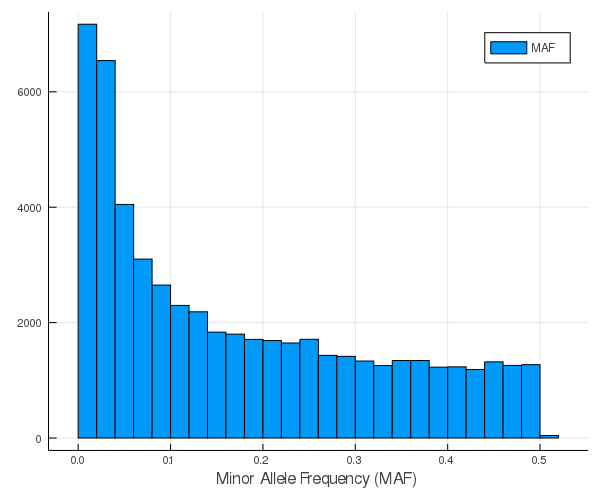

In [19]:
using Plots, PyPlot

gr(size=(600,500), html_output_format=:png)
histogram(maf_EUR, xlab = "Minor Allele Frequency (MAF)", label = "MAF")

In [11]:
# proportion of rare SNPs with maf < 0.05
count(!iszero, maf_EUR .< 0.05) / length(maf_EUR)

0.2914839688442397

### Empirical kinship matrix

We estimate empirical kinship based on all SNPs by the genetic relation matrix (GRM). If there are missing genotypes, they are imputed on the fly by drawing according to the minor allele frequencies.

In [50]:
## GRM using SNPs with maf > 0.01 (default) 
using Random 
Random.seed!(123)
@time Φgrm = grm(EUR_subset; method = :GRM)

  0.472857 seconds (35 allocations: 2.345 MiB)


379×379 Array{Float64,2}:
  0.526913     -0.010026     -0.0012793    …   0.00536883    0.00713397 
 -0.010026      0.500049      0.00147092      -0.00178778   -0.00344277 
 -0.0012793     0.00147092    0.521904        -0.0109387    -0.00262695 
 -0.00239381    0.00550462    0.00755985      -0.00265867   -0.000141742
 -0.00391296    0.00422806    0.0222034       -0.0107694    -0.00248895 
 -0.000555581   0.000696874   0.0125771    …  -0.0100831    -0.00575495 
 -0.0095376     0.00231344   -0.00259641      -0.00282701    0.000732385
 -0.00823869    0.00556861    0.0060825       -0.00911662   -0.00638629 
  0.00117402   -0.00444907   -0.0029182       -0.00244795    0.00634087 
 -0.0111617     0.00436269    0.000537307     -0.00483523   -0.00621726 
 -0.00252813   -0.000626719   0.00753937   …  -0.00180836    0.00714953 
  0.0112036    -0.0024306     0.00446458      -0.00983116   -0.00296109 
 -0.000451414   0.00707358   -0.00620136      -0.00473171   -0.00720874 
  ⋮                      

### Simulating phenotypes 


We simulate phenotype vector from

$$\mathbf{y} \sim \text{Normal}(\mathbf{1}, 0.1 \widehat{\Phi} + 0.9 \mathbf{I})$$

where $\widehat{\Phi}$ is the estimated empirical kinship matrix `Φgrm`. 

The data should be available in `pheno.txt`.

In [13]:
# using LinearAlgebra, DelimitedFiles
# Random.seed!(1234)
# Ω = 0.1 * Φgrm + 0.9 * Matrix(1.0*I, nobs, nobs)
# Ωchol = cholesky(Symmetric(Ω))
# y = ones(nobs) + Ωchol.L * randn(nobs)
# writedlm("pheno.txt", y)

### Phenotypes 

Read in the phenotype data and plot a histogram.

In [51]:
using DelimitedFiles 
y = readdlm("pheno.txt")

379×1 Array{Float64,2}:
  1.846582104608307  
  0.12019614558345848
  0.5172368025545149 
  0.11933401051509984
  1.8407354203053767 
  3.155309404417616  
  1.518422163488851  
  0.737544574135081  
  1.4904102203720164 
  0.4942945743765427 
  0.4566487030521649 
  0.9830094325553045 
  1.1241872723791884 
  ⋮                  
  0.03800817892237962
  0.7685596964598539 
  0.9285816069462199 
 -1.3005655794765896 
  1.27142883079584   
  1.8149274022746835 
  2.353663701577899  
  1.3085170568729798 
  1.2023649250831836 
  2.523945778298307  
  2.339893360260807  
  0.08293644385047372

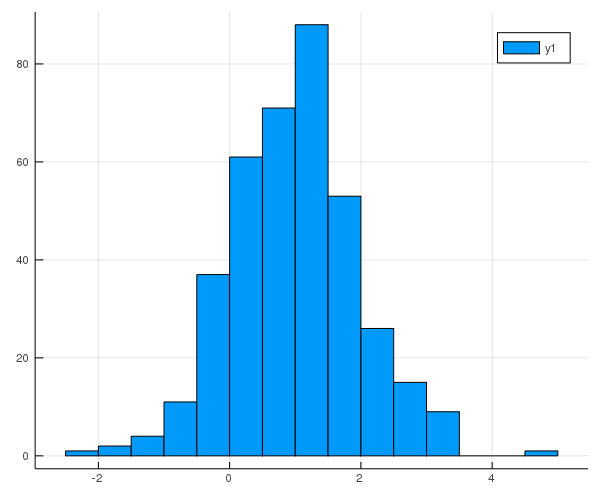

In [22]:
histogram(y)

### Pre-processing data for heritability analysis

To prepare variance component model fitting, we form an instance of VarianceComponentVariate. The two covariance matrices are $(2\Phi, I)$.

In [52]:
using VarianceComponentModels, LinearAlgebra

# form data as VarianceComponentVariate
EURdata = VarianceComponentVariate(y, ones(nobs), (2Φgrm, Matrix(1.0I, nobs, nobs)))
fieldnames(typeof(EURdata))

(:Y, :X, :V)

In [53]:
EURdata

VarianceComponentVariate{Float64,2,Array{Float64,2},Array{Float64,2},Array{Float64,2}}([1.846582104608307; 0.12019614558345848; … ; 2.339893360260807; 0.08293644385047372], Array{Float64}(undef,379,0), ([1.053826221313203 -0.020052039279012966 … 0.010737654900514952 0.014267936018676375; -0.020052039279012966 1.0000975487266066 … -0.0035755533910532874 -0.0068855303347012935; … ; 0.010737654900514952 -0.0035755533910532874 … 0.9859187797469418 0.02634099295946666; 0.014267936018676375 -0.0068855303347012935 … 0.02634099295946666 1.0243852451056223], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]))

Before fitting the variance component model, we pre-compute the eigen-decomposition of $2\Phi_{\text{GRM}}$, the rotated responses, and the constant part in log-likelihood, and store them as a TwoVarCompVariateRotate instance, which is re-used in various variane component estimation procedures.

In [54]:
# pre-compute eigen-decomposition 
@time EURdata_rotated = TwoVarCompVariateRotate(EURdata)
fieldnames(typeof(EURdata_rotated))

  0.037873 seconds (23 allocations: 3.434 MiB)


(:Yrot, :Xrot, :eigval, :eigvec, :logdetV2)

### Heritability of single trait 

We use Fisher scoring algorithm to fit variance component model for our trait. 

In [55]:
fieldnames(typeof(EURdata_rotated))

(:Yrot, :Xrot, :eigval, :eigvec, :logdetV2)

In [56]:
# form data set for trait 
trait_data = TwoVarCompVariateRotate(EURdata_rotated.Yrot, 
    EURdata_rotated.Xrot, EURdata_rotated.eigval, EURdata_rotated.eigvec, 
    EURdata_rotated.logdetV2)

# initialize model parameters
trait_model = VarianceComponentModel(trait_data)

# estimate variance components
_, _, _, Σcov, = mle_fs!(trait_model, trait_data; solver=:Ipopt, verbose=true)
σ2a = trait_model.Σ[1][1]
σ2e = trait_model.Σ[2][1]
@show σ2a, σ2e

# heritability and its standard error from single trait analysis
h, hse = heritability(trait_model.Σ, Σcov)


[h[1], hse[1]]

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

2-element Array{Float64,1}:
 1.2867667603125177e-31
 0.5784225079243387    

We can also run MM algorithm. 

In [57]:
trait_model = VarianceComponentModel(trait_data)
@time _, _, _, Σcov, = mle_mm!(trait_model, trait_data; verbose=true)
trait_model


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -7.530488e+02
       1  -6.992567e+02
       2  -6.834732e+02
       3  -6.754060e+02
       4  -6.705629e+02
       5  -6.674868e+02
       6  -6.654729e+02
       7  -6.641257e+02
       8  -6.632097e+02
       9  -6.625792e+02
      10  -6.621412e+02
      20  -6.611346e+02
      30  -6.611025e+02
      40  -6.611014e+02

  0.004867 seconds (8.48 k allocations: 386.328 KiB)


VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(Array{Float64}(undef,0,1), ([2.5702249946126256e-7], [1.9170442041975597]), Array{Float64}(undef,0,0), Char[], Float64[], -Inf, Inf)

Heritability and its standard error.

In [58]:
h, hse = heritability(trait_model.Σ, Σcov)
[h[1], hse[1]]

2-element Array{Float64,1}:
 1.3407226835922546e-7
 0.5784224797996225   

### Multivariate trait analysis

Joint analysis of multiple traits is subject to intensive research recently. For detailed analysis, go to [`VarianceComponentModels` documentation](https://openmendel.github.io/VarianceComponentModels.jl/latest/man/heritability/). 

## Heritability II 
credit: [Heritability tutorial by Sarah Ji, Janet Sinsheimer and Hua Zhou](https://github.com/OpenMendel/Tutorials/blob/master/Heritability/HERITABILITY-VCexample.ipynb)

### Fit the null model

In [61]:
using VarianceComponentModels
# Null data model has two variance components but no SNP fixed effects
# form data as VarianceComponentVariate matrix 
X = ones(nobs)
nulldata = VarianceComponentVariate(y, X, (2Φgrm, Matrix(1.0I, nobs, nobs)))

VarianceComponentVariate{Float64,2,Array{Float64,2},Array{Float64,1},Array{Float64,2}}([1.846582104608307; 0.12019614558345848; … ; 2.339893360260807; 0.08293644385047372], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], ([1.053826221313203 -0.020052039279012966 … 0.010737654900514952 0.014267936018676375; -0.020052039279012966 1.0000975487266066 … -0.0035755533910532874 -0.0068855303347012935; … ; 0.010737654900514952 -0.0035755533910532874 … 0.9859187797469418 0.02634099295946666; 0.014267936018676375 -0.0068855303347012935 … 0.02634099295946666 1.0243852451056223], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]))

In [63]:
nullmodel = VarianceComponentModel(nulldata)

VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}([0.0], ([1.0], [1.0]), Array{Float64}(undef,0,1), Char[], Float64[], -Inf, Inf)

In [64]:
@time nulllogl, nullmodel, = fit_mle!(nullmodel, nulldata; algo = :FS)

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

(-523.9161903359078, VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}([0.9900140588281162], ([0.5360487493497349], [0.39861050027076955]), Array{Float64}(undef,0,1), Char[], Float64[], -Inf, Inf), ([0.2872182098049488], [0.2789237673497682]), [0.08249430004355958 -0.07781584431646911; -0.07781584431646914 0.07779846799258762], [0.03243058347883627], [0.001051742744777768])

The null model log-likelihood (no SNP effects)

In [65]:
nulllogl

-523.9161903359078

The null model mean effects (a grand mean)

In [66]:
nullmodel.B

1×1 Array{Float64,2}:
 0.9900140588281162

The null model additive genetic variance

In [67]:
nullmodel.Σ[1]

1×1 Array{Float64,2}:
 0.5360487493497349

The null model environmental variance

In [68]:
nullmodel.Σ[2]

1×1 Array{Float64,2}:
 0.39861050027076955

### Heritability
Calculate the proportion of the variance that can be attributed to additive genetic effects, the narrow sense heritability. We calculate it here without any SNPs included.

In [70]:
her_null = nullmodel.Σ[1] / (nullmodel.Σ[1] + nullmodel.Σ[2])

1×1 Array{Float64,2}:
 0.5735231845909452